#Dataset and Imports

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/BT4222_Group_5_Submission/processed_datasets/movies_and_reviews.csv')

Mounted at /content/drive


In [3]:
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
import ast
import random
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import math

In [4]:
# Extract the necessary columns
dataset = df[['movie_title','reviewer_name','reviewer_rating','movie_genre']].copy()
dataset.head()

,movie_title,reviewer_name,reviewer_rating,movie_genre
0,the birth of a nation (1915),Cineanalyst,10.0,"['Biography', 'Drama', 'History', 'War']"
1,the birth of a nation (1915),Auburn668,10.0,"['Biography', 'Drama', 'History', 'War']"
2,the birth of a nation (1915),mozart182,9.0,"['Biography', 'Drama', 'History', 'War']"
3,the birth of a nation (1915),smithmjsjsmith,10.0,"['Biography', 'Drama', 'History', 'War']"
4,the birth of a nation (1915),sharkey197,7.0,"['Biography', 'Drama', 'History', 'War']"


### Data preprocessing + Feature engineering

Make Genres an Embedding layer which will be passed into the model

Change movie genre data type from "['Biography', 'Drama', 'History', 'War']" to ['Biography', 'Drama', 'History', 'War']

In [5]:
dataset['movie_genre'] = dataset['movie_genre'].apply(ast.literal_eval)

In [6]:
# Find all unqiue genres & max number of genres a movie has
unique_genres = []
max_len = 0
for d in dataset['movie_genre']:
  if len(d) > max_len:
    max_len = len(d)

  for indiv in d:
    if indiv not in unique_genres:
      unique_genres.append(indiv)

print("Number of unique genres:", len(unique_genres))
print("Unique genres:", unique_genres)
print("Max number of genres in a movie:", max_len)

Number of unique genres: 25
Unique genres: ['Biography', 'Drama', 'History', 'War', 'Animation', 'Family', 'Fantasy', 'Romance', 'Adventure', 'Comedy', 'Mystery', 'Thriller', 'Holiday', 'Kids', 'Music', 'Crime', 'Action', 'Horror', 'Sport', 'Musical', 'Science Fiction', 'Western', 'Anime', 'Lgbtq+', 'Documentary']
Max number of genres in a movie: 8


We create a One Hot Vector of all genres (length 25) as rows with null values have been removed in our data processing so all rows have genre(s) present.

In [7]:
# List of genres
genres = unique_genres

# Create a dictionary mapping each genre to an index
genre_to_index = {genre: index for index, genre in enumerate(genres)}

# Initialize a list of zeros with a length of 25
one_hot_vector = [0] * 25

# Function to create a one-hot vector
def create_one_hot_vector(genre):
    one_hot_vector = [0] * 25
    for ele in genre:
      index = genre_to_index.get(ele)
      if index is not None:
          one_hot_vector[index] = 1
    return torch.tensor(one_hot_vector, dtype=torch.long)

# Example usage
selected_genre = ["History", "Comedy", "Mystery", "Crime", "Thriller"]
one_hot_vector = create_one_hot_vector(selected_genre)
print(one_hot_vector)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


In [8]:
# Add padded_tensor to dataset
dataset['padded_genre'] = dataset['movie_genre']
dataset['padded_tensor'] = dataset['movie_genre'].apply(lambda x:create_one_hot_vector(x))

In [9]:
# Normalise rating
dataset['normalized_rating'] = (dataset['reviewer_rating'] - dataset['reviewer_rating'].min()) / (dataset['reviewer_rating'].max() - dataset['reviewer_rating'].min())

In [10]:
dataset['normalized_rating'].describe()

,normalized_rating
count,798587.000000
mean,0.720746
std,0.285934
min,0.000000
25%,0.600000
50%,0.800000
75%,1.000000
max,1.000000


In [10]:
dataset.head()

,movie_title,reviewer_name,reviewer_rating,movie_genre,padded_genre,padded_tensor,normalized_rating
0,the birth of a nation (1915),Cineanalyst,10.0,"[Biography, Drama, History, War]","[Biography, Drama, History, War]","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1.0
1,the birth of a nation (1915),Auburn668,10.0,"[Biography, Drama, History, War]","[Biography, Drama, History, War]","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1.0
2,the birth of a nation (1915),mozart182,9.0,"[Biography, Drama, History, War]","[Biography, Drama, History, War]","[tensor(1), tensor(1), tensor(1), tensor(1), t...",0.9
3,the birth of a nation (1915),smithmjsjsmith,10.0,"[Biography, Drama, History, War]","[Biography, Drama, History, War]","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1.0
4,the birth of a nation (1915),sharkey197,7.0,"[Biography, Drama, History, War]","[Biography, Drama, History, War]","[tensor(1), tensor(1), tensor(1), tensor(1), t...",0.7


Counting Unique Users and Movies which will be useful for setting up embeddings later.

In [11]:
num_users = dataset['reviewer_name'].nunique()
num_movies = dataset['movie_title'].nunique()
print("Number of unique users:", num_users)
print("Number of unique movies:", num_movies)

Number of unique users: 371203
Number of unique movies: 2102


Check genre distribution across movies

<ipython-input-13-0dbbbd6649f3>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


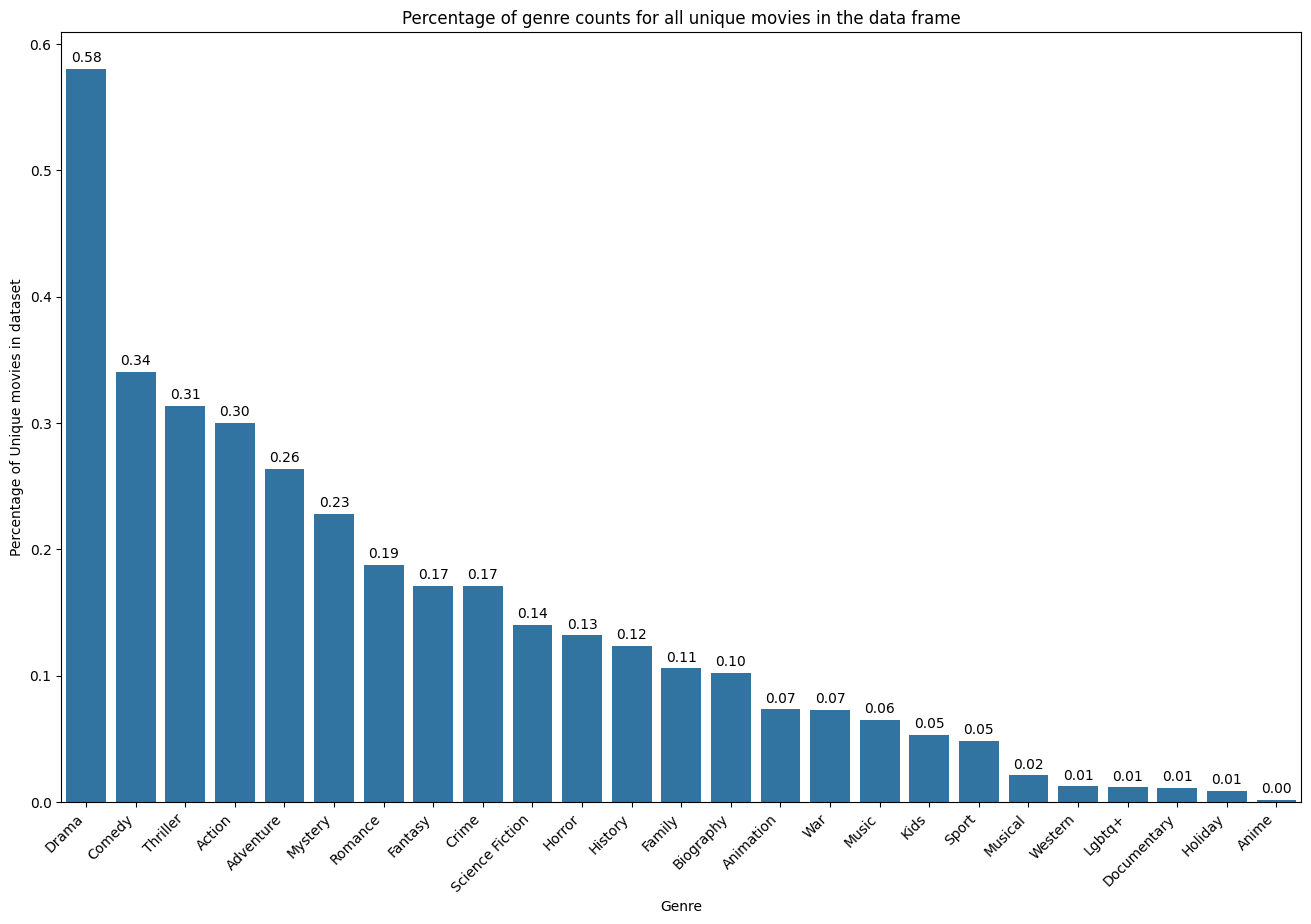

In [13]:
unique_movies = []
for d in dataset['movie_title']:
  if d not in unique_movies:
    unique_movies.append(d)

genre_counts = {}

for movie_title in unique_movies:
    movie_row = dataset[dataset['movie_title'] == movie_title].iloc[0]
    genres = movie_row['movie_genre']

    for genre in genres:
        if genre not in genre_counts:
            genre_counts[genre] = 1
        else:
            genre_counts[genre] += 1

df_genre_counts = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Counts'])
df_genre_counts = df_genre_counts.sort_values(by='Counts', ascending=False)

genre_counts_percent = {genre: count / 2102 for genre, count in genre_counts.items()}

sorted_genre_counts_percent = dict(sorted(genre_counts_percent.items(), key=lambda item: item[1], reverse=True))

df_genre_counts = pd.DataFrame(list(sorted_genre_counts_percent.items()), columns=['Genre', 'Percentage of Unique movies in dataset'])

plt.figure(figsize=(16, 10))
ax = sns.barplot(x='Genre', y='Percentage of Unique movies in dataset', data=df_genre_counts)
ax.bar_label(ax.containers[0], fontsize=10, padding=3, fmt='%.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title('Percentage of genre counts for all unique movies in the data frame')
plt.show()

Encoding of User and Movie IDs

In [12]:
user_en = preprocessing.LabelEncoder()
movie_en = preprocessing.LabelEncoder()
dataset['reviewer_name'] = user_en.fit_transform(dataset['reviewer_name'])
dataset['movie_title'] =  movie_en.fit_transform(dataset['movie_title'])

Splitting the Data into Training and Validation Sets - We set aside 70% for training, 15% for validation and 15% for testing

In [13]:
# Step 1: Split the data into initial training (70%) and temporary set (30%)
train_data, temp_data = model_selection.train_test_split(dataset, test_size=0.3, random_state=42)

# Step 2: Split the temporary set into validation (50% of temp, or 15% of total) and test (50% of temp, or 15% of total)
val_data, test_data = model_selection.train_test_split(temp_data, test_size=0.5, random_state=42)

# Step 3: Filter the validation and test sets to include only users and items present in the training set
train_users = train_data["reviewer_name"].unique()
train_items = train_data["movie_title"].unique()

val_data = val_data[val_data["reviewer_name"].isin(train_users) & val_data["movie_title"].isin(train_items)]
test_data = test_data[test_data["reviewer_name"].isin(train_users) & test_data["movie_title"].isin(train_items)]

In [14]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

559010
73031
72621


In [14]:
class MovieNReview:
    def __init__(self, users, movies, ratings, genres):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.genres = genres

    def __len__(self):
        return len(self.users)  # Number of samples in the dataset

    def __getitem__(self, item):
        # Get the data at the specified index
        user = self.users[item]
        movie = self.movies[item]
        rating = self.ratings[item]
        genre = self.genres[item]

        # Convert data to tensors
        user_tensor = torch.tensor(user, dtype=torch.long)
        movie_tensor = torch.tensor(movie, dtype=torch.long)
        rating_tensor = torch.tensor(rating, dtype=torch.float)

        # If genre is already a tensor, use it as is; otherwise, convert it to a tensor
        if isinstance(genre, torch.Tensor):
            genre_tensor = genre
        else:
            genre_tensor = torch.tensor(genre, dtype=torch.long)

        # Return a dictionary with all items
        return {
            "user": user_tensor,
            "movie": movie_tensor,
            "rating": rating_tensor,
            "genre": genre_tensor
        }


Creating Dataset Instances for Training, Testing and Validation

In [15]:
train_dataset = MovieNReview(
    users=train_data['reviewer_name'].values,
    movies=train_data['movie_title'].values,
    ratings=train_data['normalized_rating'].values,
    genres=train_data['padded_tensor'].values
)

test_dataset = MovieNReview(
    users=test_data['reviewer_name'].values,
    movies=test_data['movie_title'].values,
    ratings=test_data['normalized_rating'].values,
    genres=test_data['padded_tensor'].values
)

validation_dataset = MovieNReview(
    users=val_data['reviewer_name'].values,
    movies=val_data['movie_title'].values,
    ratings=val_data['normalized_rating'].values,
    genres=val_data['padded_tensor'].values
)

Setting Up Data Loaders

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
  validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
  validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
  print("Using CPU")


Using GPU: Tesla T4


# Neural Collaborative Filtering (NCF)

Neural Collaborative Filtering (NCF) is a deep learning-based approach to collaborative filtering, which is commonly used in recommender systems. Unlike traditional collaborative filtering methods (such as matrix factorization), NCF uses neural networks to model the interaction between users and items for recommendation.

## Multi-Layer Perceptron (MLP)-based collaborative filtering model

In this model, we apply neural networks to model the complex relationships and collaborative effects between users and ratings, something that matrix factorization struggles to capture since it only involves matrix multiplication. By using neural networks with hidden layers, we are able to more effectively learn and represent these interactions.

The model takes user and movie embeddings as inputs, where the one-hot vectors (OHV) of users and movies are transformed into lower-dimensional embeddings that serve as lookup tables. The network then adjusts these embeddings based on the loss function during training.

**Model Definition**

In [117]:
class NCFModel1(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=32, hidden_dim=32, dropout_rate=0.2):
        super(NCFModel1, self).__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Fully connected layers
        self.fc1 = nn.Linear(2 * embedding_size, hidden_dim)  # Concatenate user and movie embeddings
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output layer

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, user, movie):
        # Get embeddings for users and movies
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through fully connected layers with ReLU activation
        x = self.relu(self.fc1(combined))

        # Apply dropout
        x = self.dropout(x)

        # Output predicted rating
        output = self.fc2(x)

        return output


**Model Training**

In [118]:
# Initialize model
recommendation_model = NCFModel1(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_)
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [119]:
EPOCHS = 2
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for step, train_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)):
        # Move data to device
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)

        # Forward pass
        output = recommendation_model(users, movies)

        # Reshape output to match target shape
        output = output.squeeze()  # Removes the singleton dimension, changing from [5, 1] to [5]

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally log progress every 100 steps
        # if step % 100 == 0:
        #     print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Average Loss: 0.0759


Epoch 2, Average Loss: 0.0703


**Model Evaluation**

In [17]:
# Set threshold for recommendation
recommendation_threshold = dataset['normalized_rating'].mean()
print(f"Recommendation Threshold: {recommendation_threshold}")

Recommendation Threshold: 0.7207461348579556


In [18]:
# Recommendation criteria
def recommend(val, threshold):
    return 1 if val > threshold else 0

# Function to calculate Precision, Recall at Top-k
def calc_PRA(user_ratings, k, recommendation_threshold=0.9):
    # Sort user_ratings in descending order based on the predicted rating (first element)
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    # The number of recommended items that are predicted relevant and within top-k
    n_rec_k = sum(est >= recommendation_threshold for est, _ in user_ratings[:k])

    # The number of actual relevant items within top-k
    n_rel_k = sum(true_r >= recommendation_threshold for _, true_r in user_ratings[:k])

    # The number of recommended items that are actually relevant within top-k
    n_rel_and_rec_k = sum((true_r >= recommendation_threshold) and (est >= recommendation_threshold) for est, true_r in user_ratings[:k])

    # Precision: proportion of recommended relevant items in top-k
    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

    # Recall: proportion of actual relevant items in top-k
    recall = n_rel_and_rec_k / n_rel_k if n_rel_k != 0 else 1

    return precision, recall

def calculate_ndcg(user_ratings, k, threshold):
    """
    Calculate NDCG@k for a set of user ratings based on predicted relevance and actual relevance.

    :param user_ratings: List of tuples, each containing (predicted_rating, true_rating).
    :param k: The number of top recommendations to consider for NDCG.
    :param threshold: The threshold for relevance; ratings above this are considered relevant.
    :return: NDCG score.
    """

    # Sort user_ratings in descending order based on predicted rating (first element)
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    # Calculate DCG (Discounted Cumulative Gain)
    dcg = 0
    for i in range(min(k, len(user_ratings))):
        rel = 1 if user_ratings[i][1] >= threshold else 0  # Relevance score: binary (1 or 0)
        dcg += rel / math.log2(i + 2)  # Log base 2

    # Calculate IDCG (Ideal DCG), which is the DCG for the ideal ranking (best relevance order)
    ideal_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)  # Sort by true relevance
    idcg = 0
    for i in range(min(k, len(ideal_ratings))):
        rel = 1 if ideal_ratings[i][1] >= threshold else 0
        idcg += rel / math.log2(i + 2)

    # Calculate NDCG
    ndcg = dcg / idcg if idcg != 0 else 0  # Avoid division by zero

    return ndcg


In [120]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred[0].item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred[0].item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8654
Average recall of top 5 movies recommended for all users - validation: 0.7108
Average F1 score of top 5 movies recommended for all users - validation: 0.6102
Average NDCG@5 of top movies recommended for all users - validation: 0.6276


Calculate Average Metrics

* Precision: The proportion of recommended movies that are relevant.

* Recall: The proportion of relevant movies that have been recommended.

* F1 score: The harmonic mean of precision and recall.

* NDCG: Normalized Discounted Cumulative Gain (NDCG) is a metric used to assess the quality of a ranking system by evaluating how well it orders items based on relevance.


### Hyperparameter tuning

* Add complexity to the model by increasing hidden layers, now with dimensions (64, 32, 16).
  * By adding more layers with different numbers of units (64, 32, 16), Model 2 can learn more intricate patterns and relationships in the data, potentially improving its ability to make accurate recommendations.
  * In Model 2, the smaller embedding size (64 instead of 128) could help in reducing the number of model parameters, leading to faster training and preventing overfitting, especially if the dataset is not extremely large.
* Increased number of training epochs from 2 to 4.
  * Increasing epochs in Model 2 allows the model more time to learn and adjust the weights, leading to improved performance. Since Model 2 has a more complex architecture, it may require more epochs to fully converge.

In [64]:
class NCFModel2(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=64,
        hidden_dim=(64, 32, 16),  # Hidden layers with different sizes
        dropout_rate=0.2,
    ):
        super(NCFModel2, self).__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # CHANGE
        # Building the MLP (Hidden layers setup)
        hidden_layers = []
        input_units = 2 * embedding_size  # The concatenated user and movie embeddings
        for num_units in hidden_dim:
            hidden_layers.append(nn.Linear(input_units, num_units))
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Dropout(p=dropout_rate))
            input_units = num_units  # Update input size for the next layer

        # Final output layer (rating prediction)
        hidden_layers.append(nn.Linear(hidden_dim[-1], 1))  # Output layer with 1 unit for rating prediction

        # Define the MLP as a sequential container
        self.MLP = nn.Sequential(*hidden_layers)

    def forward(self, user, movie):
        # Get embeddings for users and movies
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through the MLP to predict the rating
        output = self.MLP(combined)

        return output

### Training and Validation

In [65]:
# Initialize model
recommendation_model = NCFModel2(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_)
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for step, train_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)):
        # Move data to device
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)

        # Forward pass
        output = recommendation_model(users, movies)

        # Reshape output to match target shape
        output = output.squeeze()  # Removes the singleton dimension, changing from [5, 1] to [5]

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally log progress every 100 steps
        # if step % 100 == 0:
        #     print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Average Loss: 0.0753


Epoch 2, Average Loss: 0.0686


Epoch 3, Average Loss: 0.0636


Epoch 4, Average Loss: 0.0581


In [66]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred[0].item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred[0].item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8203
Average recall of top 5 movies recommended for all users - validation: 0.8222
Average F1 score of top 5 movies recommended for all users - validation: 0.6692
Average NDCG@5 of top movies recommended for all users - validation: 0.6265


**Analysis and Comparison (Model 1 and 2):**

NCFModel1
* Average precision of top 5 movies recommended for all users - validation: 0.8654
* Average recall of top 5 movies recommended for all users - validation: 0.7108
* Average F1 score of top 5 movies recommended for all users - validation: 0.6102
* Average NDCG@5 of top movies recommended for all users - validation: 0.6276


NCFModel2
* Average precision of top 5 movies recommended for all users - validation: 0.8203
* Average recall of top 5 movies recommended for all users - validation: 0.8222
* Average F1 score of top 5 movies recommended for all users - validation: 0.6692
* Average NDCG@5 of top movies recommended for all users - validation: 0.6265

NCFModel2 has a higher F1 score (0.6692) compared to NCFModel1 (0.6102), indicating that it provides a better balance between precision and recall.
In a recommendation system, we want to ensure that the items we recommend are relevant to the users (precision) while also ensuring that the system recommends as many relevant items as possible (recall). The higher F1 score in NCFModel2 shows that it performs better in retrieving relevant recommendations, which is often more critical when the goal is to recommend items that users will engage with.

NDCG@5, which evaluates the ranking of the top 5 recommended items, shows that both models perform similarly (0.6276 for NCFModel1 vs. 0.6265 for NCFModel2). While NCFModel1 has a slight edge in NDCG, the difference is minimal.
This suggests that the ranking quality of the top 5 items in both models is quite similar.

Model Choice:
Since NCFModel2 provides a better balance of precision and recall without sacrificing ranking quality, it is a more robust choice for ensuring relevant recommendations are made efficiently.

### MLP + genre

The NCFModelWithGenre class is similar to the previous model (NCFModel2), but is enhanced with genre information hoping to improve movie rating predictions. It combines user embeddings, movie embeddings, and genre embeddings to predict a user's rating for a particular movie.

Additionally, due to the skewed genre distribution as seen above, we experimented with both normalized and non-normalized genre embeddings to determine which approach yields better performance. In the case of normalization, we subtracted the mean and divided by the standard deviation to stabilize the learning process, ensuring the embeddings are centered around zero and have a consistent scale. After normalization, the genre embeddings are averaged across the genre dimension to combine the multiple genres associated with a movie.

In [68]:
class NCFModelWithGenre1(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        num_genres,  # Number of unique genres
        embedding_size=64,
        hidden_dim=(64, 32, 16),  # Sizes of hidden layers
        dropout_rate=0.2,
    ):
        super(NCFModelWithGenre1, self).__init__()

        # Embedding layers for users, movies, and genres
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size)

        # Build the MLP (Hidden layers setup)
        hidden_layers = []
        input_units = 3 * embedding_size  # Concatenate user, movie, and genre embeddings
        for num_units in hidden_dim:
            hidden_layers.append(nn.Linear(input_units, num_units))
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Dropout(p=dropout_rate))
            input_units = num_units  # Update input size for the next layer

        # Final output layer for rating prediction
        hidden_layers.append(nn.Linear(hidden_dim[-1], 1))

        # Define the MLP as a sequential container
        self.MLP = nn.Sequential(*hidden_layers)

    def forward(self, user, movie, genre):
        # Get embeddings for users and movies
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)

        # Get genre embeddings
        genre_embedded = self.genre_embedding(genre)

        # Normalize genre embeddings (mean and std normalization)
        genre_embedded = self.normalize_embeddings(genre_embedded)

        #Take average along the genre dimension (dim=1)
        genre_embedded = genre_embedded.mean(dim=1)

        # Concatenate user, movie, and normalized genre embeddings
        combined = torch.cat([user_embedded, movie_embedded, genre_embedded], dim=1)

        # Pass through the MLP to predict the rating
        output = self.MLP(combined)

        return output

    def normalize_embeddings(self, genre_embedded):
        """
        Normalize genre embeddings by subtracting the mean and dividing by the standard deviation.
        This is weight normalization for the genre embeddings.
        """
        # Compute mean and std across the batch (dim=0)
        mean = genre_embedded.mean(dim=0, keepdim=True)
        std = genre_embedded.std(dim=0, keepdim=True) + 1e-6  # Adding epsilon for numerical stability

        # Normalize the embeddings
        genre_embedded_normalized = (genre_embedded - mean) / std

        return genre_embedded_normalized

NCF Model + Genre (No Normalization)

In [28]:
class NCFModelWithGenre2(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        num_genres,  # Number of unique genres
        embedding_size=64,
        hidden_dim=(64, 32, 16),  # Sizes of hidden layers
        dropout_rate=0.2,
    ):
        super(NCFModelWithGenre2, self).__init__()

        # Embedding layers for users, movies, and genres
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size)

        # Build the MLP (Hidden layers setup)
        hidden_layers = []
        input_units = 3 * embedding_size  # Concatenate user, movie, and genre embeddings
        for num_units in hidden_dim:
            hidden_layers.append(nn.Linear(input_units, num_units))
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Dropout(p=dropout_rate))
            input_units = num_units  # Update input size for the next layer

        # Final output layer for rating prediction
        hidden_layers.append(nn.Linear(hidden_dim[-1], 1))

        # Define the MLP as a sequential container
        self.MLP = nn.Sequential(*hidden_layers)

    def forward(self, user, movie, genre):
        # Get embeddings for users, movies, and genres
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        genre_embedded = self.genre_embedding(genre)

        # Take the average of genre embeddings (along the genre dimension)
        genre_embedded = genre_embedded.mean(dim=1)

        # Concatenate user, movie, and genre embeddings
        combined = torch.cat([user_embedded, movie_embedded, genre_embedded], dim=1)

        # Pass through the MLP to predict the rating
        output = self.MLP(combined)

        return output


### Training and Validation

Training (NCFModelWithGenre1)

In [76]:
# Initialize model
recommendation_model = NCFModelWithGenre1(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_),
    num_genres=25
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for step, train_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)):
        # Move data to device
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)
        genres = train_data["genre"].to(device)  # Include the genre data

        # Forward pass
        output = recommendation_model(users, movies, genres)

        # Reshape output to match target shape
        output = output.squeeze()  # Removes the singleton dimension, changing from [5, 1] to [5]

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally log progress every 100 steps
        # if step % 100 == 0:
        #     print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Average Loss: 0.0739


Epoch 2, Average Loss: 0.0685


Epoch 3, Average Loss: 0.0637


Epoch 4, Average Loss: 0.0581


Validation (NCFModelWithGenre1)

In [78]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)
        genres = valid_data["genre"].to(device)  # Include the genre data

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred[0].item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred[0].item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8185
Average recall of top 5 movies recommended for all users - validation: 0.8252
Average F1 score of top 5 movies recommended for all users - validation: 0.6694
Average NDCG@5 of top movies recommended for all users - validation: 0.6272


Training (NCFModelWithGenre2)

In [29]:
# Initialize model
recommendation_model = NCFModelWithGenre2(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_),
    num_genres=25
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for step, train_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)):
        # Move data to device
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)
        genres = train_data["genre"].to(device)  # Include the genre data

        # Forward pass
        output = recommendation_model(users, movies, genres)

        # Reshape output to match target shape
        output = output.squeeze()  # Removes the singleton dimension, changing from [5, 1] to [5]

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally log progress every 100 steps
        # if step % 100 == 0:
        #     print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Print average loss after each epoch
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Average Loss: 0.0780


Epoch 2, Average Loss: 0.0683


Epoch 3, Average Loss: 0.0637


Epoch 4, Average Loss: 0.0581


Validation(NCFModelWithGenre2)

In [30]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)
        genres = valid_data["genre"].to(device)  # Include the genre data

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred[0].item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred[0].item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8298
Average recall of top 5 movies recommended for all users - validation: 0.8123
Average F1 score of top 5 movies recommended for all users - validation: 0.6693
Average NDCG@5 of top movies recommended for all users - validation: 0.6271


### Model comparison and analysis

**NCFModelWithGenre1 VS NCFModelWithGenre2**

NCFModelWithGenre1 (Normalization)
* Average precision of top 5 movies recommended for all users - validation: 0.8185
* Average recall of top 5 movies recommended for all users - validation: 0.8252
* Average F1 score of top 5 movies recommended for all users - validation: 0.6694
* Average NDCG@5 of top movies recommended for all users - validation: 0.6272

NCFModelWithGenre2 (No Normalization)
* Average precision of top 5 movies recommended for all users - validation: 0.8298
* Average recall of top 5 movies recommended for all users - validation: 0.8123
* Average F1 score of top 5 movies recommended for all users - validation: 0.6693
* Average NDCG@5 of top movies recommended for all users - validation: 0.6271

Analysis:
We can see that both models have similar F1 scores and NDCG values. However, NCFModelWithGenre1 performs worse in precision and better in recall while NCFModelWithGenre2 is the opposite.
From the user perspective, they will likely appreciate a top 5 recommendation list that contains more relevant movies (higher precision) even if it means that fewer total relevant items are included (slightly lower recall). The key to a successful recommendation system is the user's ability to quickly find something they enjoy without sifting through a broad, irrelevant set of recommendations. Hence we prefer NCFModelWithGenre2 as with its higher precision, it is better at providing that focused, relevant list that a user is more likely to engage with.

**NCFModel2 VS NCFModelWithGenre2**

NCFModel2

* Average precision of top 5 movies recommended for all users - validation: 0.8203
* Average recall of top 5 movies recommended for all users - validation: 0.8222
* Average F1 score of top 5 movies recommended for all users - validation: 0.6692
* Average NDCG@5 of top movies recommended for all users - validation: 0.6265

NCFModelWithGenre2

* Average precision of top 5 movies recommended for all users - validation: 0.8298
* Average recall of top 5 movies recommended for all users - validation: 0.8123
* Average F1 score of top 5 movies recommended for all users - validation: 0.6693
* Average NDCG@5 of top movies recommended for all users - validation: 0.6271

Analysis: NCFModel2 and NCFModelWithGenre2 have similar F1 score. NCFModel2 has a slightly lower precision and higher recall than NCFModelWithGenre2. NDCG (Normalized Discounted Cumulative Gain) measures the quality of recommendations by considering both the relevance and the ranking of the recommended movies. NCFWithGenre has a slightly better NDCG, which implies that not only are relevant movies recommended, but they are also ranked higher in the list.

Conclusion:

Although the differences in performance metrics are subtle, NCFWithGenre2 shows a slight improvement over NCFModel2, particularly in terms of precision and NDCG. Thus,incorporating genre information into the model likely enhances its ability to make better recommendations, especially in ranking relevant movies higher. Hence, we prefer NCFWithGenre2.

### Evaluation on test data and prediction

Evaluation on test data (NCFModelWithGenre2)

In [31]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommend list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the test data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for test_data in test_loader:
        users = test_data["user"].to(device)
        movies = test_data["movie"].to(device)
        ratings = test_data["rating"].to(device)
        genres = test_data["genre"].to(device)  # Include the genre data

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred[0].item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred[0].item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - test: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - test: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - test: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - test: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - test: 0.8281
Average recall of top 5 movies recommended for all users - test: 0.8120
Average F1 score of top 5 movies recommended for all users - test: 0.6681
Average NDCG@5 of top movies recommended for all users - test: 0.6260


Prediction to find top 5 recommended movies for 1 user (Cineanalyst) - NCFModelWithGenre2

In [32]:
pred_true_comparison = defaultdict(list)

# Get the user ID for Cineanalyst
cine_id = user_en.transform(['Cineanalyst'])[0]

y_test = []
y_pred = []

cine_predictions = []

# No gradient calculations required during inference
with torch.no_grad():
    for test_data in test_loader:
        users = test_data["user"].to(device)
        movies = test_data["movie"].to(device)
        ratings = test_data["rating"].to(device)
        genres = test_data["genre"].to(device)

        # Get model predictions
        outputs = recommendation_model(users, movies, genres)

        for user, pred, true, movie_id in zip(users, outputs, ratings, movies):
            # Store user-specific predictions and actual ratings
            pred_true_comparison[user.item()].append([pred.item(), true.item()])

            # Store predictions for Cineanalyst for later analysis
            if user.item() == cine_id:
                cine_predictions.append((movie_id.item(), pred.item(), true.item()))

            # Collect true ratings and predicted ratings for metrics
            y_test.append(recommend(true.item(), recommendation_threshold))  # assuming recommend() is implemented
            y_pred.append(pred.item())

# Sort Cineanalyst predictions by predicted rating, descending order
cine_predictions.sort(key=lambda x: x[1], reverse=True)

# Select top 5 recommendations based on the highest predicted ratings
top_5_recommendations = cine_predictions[:5]

# Print the top 5 recommendations for Cineanalyst
print("Top 5 recommendations for Cineanalyst:")
for movie_id, pred_rating, actual_rating in top_5_recommendations:
    # Convert movie ID to movie name
    movie_name = movie_en.inverse_transform([movie_id])[0]
    print(f"Movie: {movie_name}, Predicted Rating: {pred_rating:.2f}, Actual Rating: {actual_rating:.2f}")

Top 5 recommendations for Cineanalyst:
Movie: the wizard of oz (1939), Predicted Rating: 0.84, Actual Rating: 1.00
Movie: hidden figures (2016), Predicted Rating: 0.79, Actual Rating: 0.70
Movie: bohemian rhapsody (2018), Predicted Rating: 0.79, Actual Rating: 0.60
Movie: love and death (1975), Predicted Rating: 0.73, Actual Rating: 0.70
Movie: halloween (1978), Predicted Rating: 0.73, Actual Rating: 0.90


## NeuMF Model

The NeuMF (Neural Matrix Factorization) model combines the strengths of matrix factorization and neural networks for collaborative filtering. It consists of two pathways: the GMF (Generalized Matrix Factorization) pathway, where user and movie embeddings are multiplied element-wise to capture linear interactions, and the MLP (Multi-Layer Perceptron) pathway, where user and movie embeddings are concatenated and passed through fully connected layers to capture non-linear interactions. The outputs from both pathways are concatenated and passed through additional layers to produce the final rating prediction. This architecture allows the model to effectively learn both linear and complex, non-linear patterns in user-item interactions.

In [20]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim, dropout_rate):
        super(NeuMF, self).__init__()

        # GMF pathway components
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_gmf = nn.Embedding(num_movies, embedding_dim)

        # MLP pathway components
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_mlp = nn.Embedding(num_movies, embedding_dim)

        # MLP hidden layers
        self.fc1_mlp = nn.Linear(2 * embedding_dim, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers to combine GMF and MLP outputs
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)
        self.fc2_combined = nn.Linear(128, 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, user_id, movie_id):
        # GMF pathway
        user_gmf_emb = self.user_embedding_gmf(user_id)
        movie_gmf_emb = self.movie_embedding_gmf(movie_id)
        gmf_output = user_gmf_emb * movie_gmf_emb

        # MLP pathway
        user_mlp_emb = self.user_embedding_mlp(user_id)
        movie_mlp_emb = self.movie_embedding_mlp(movie_id)
        mlp_input = torch.cat((user_mlp_emb, movie_mlp_emb), dim=-1)

        # Pass through MLP layers
        mlp_output = F.relu(self.fc1_mlp(mlp_input))
        mlp_output = self.dropout(mlp_output)
        mlp_output = F.relu(self.fc2_mlp(mlp_output))

        # Combine GMF and MLP outputs
        combined_input = torch.cat((gmf_output, mlp_output), dim=-1)
        combined_output = F.relu(self.fc1_combined(combined_input))

        # Final output layer
        output = self.fc2_combined(combined_output)
        output = torch.sigmoid(output)

        return output.squeeze()


### Training and Validation

In [84]:
# Hyperparameters
embedding_dim = 64
dropout_rate = 0.2

# Initialize model
recommendation_model = NeuMF(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_),
    embedding_dim=embedding_dim,
    dropout_rate=dropout_rate
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

# Training loop
EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for train_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)

        # Forward pass
        output = recommendation_model(users, movies)

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.07160100035313954


Epoch 2, Loss: 0.06566235760731157


Epoch 3, Loss: 0.057407401148288476


Epoch 4, Loss: 0.04677271622643045


Evaluation with validation data

In [87]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred.item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred.item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8050
Average recall of top 5 movies recommended for all users - validation: 0.8299
Average F1 score of top 5 movies recommended for all users - validation: 0.6652
Average NDCG@5 of top movies recommended for all users - validation: 0.6262


### NeuMF model + Genre

The NeuMFWithGenre model is a hybrid Neural Collaborative Filtering (NCF) approach that integrates Generalized Matrix Factorization (GMF) and Multilayer Perceptron (MLP) pathways, incorporating genre embeddings in both. The GMF pathway captures user-movie interactions via element-wise multiplication of embeddings, with genre embeddings normalized and summed. The MLP pathway processes the embeddings through two fully connected layers, after concatenating user, movie, and averaged genre embeddings. Both outputs are combined, passed through another layer, and produce the final rating prediction.

In the model, due to the skewed genre distribution, we experimented with normalizing the genre embeddings before passing them through the MLP pathway. The normalization process scales the embeddings so that they have a unit norm (i.e., each embedding vector has a length of 1). This step is intended to improve model stability and training efficiency. We tested both the normalized and non-normalized genre embeddings to determine which approach yields better performance

NeuMFWithGenre1 (Normalization)

In [20]:
class NeuMFWithGenre1(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, embedding_dim, dropout_rate):
        super(NeuMFWithGenre1, self).__init__()

        # GMF pathway components
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_gmf = nn.Embedding(num_movies, embedding_dim)
        self.genre_embedding_gmf = nn.Embedding(num_genres, embedding_dim)  # Genre embeddings for GMF

        # MLP pathway components
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_mlp = nn.Embedding(num_movies, embedding_dim)
        self.genre_embedding_mlp = nn.Embedding(num_genres, embedding_dim)  # Genre embeddings for MLP

        # MLP hidden layers
        self.fc1_mlp = nn.Linear(2 * embedding_dim + embedding_dim, 128)  # +embedding_dim for genre
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers to combine GMF and MLP outputs
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)  # +embedding_dim for GMF and MLP
        self.fc2_combined = nn.Linear(128, 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def normalize_embeddings(self, embeddings):
        # Normalize embeddings to have unit norm (L2 normalization)
        norm = embeddings.norm(p=2, dim=-1, keepdim=True)  # L2 norm
        normalized_embeddings = embeddings / norm  # Element-wise division by the norm
        return normalized_embeddings

    def forward(self, user_id, movie_id, genre_id):
        # GMF pathway
        user_gmf_emb = self.user_embedding_gmf(user_id)
        movie_gmf_emb = self.movie_embedding_gmf(movie_id)
        genre_gmf_emb = self.genre_embedding_gmf(genre_id)  # Genre embedding for GMF

        # Normalize genre embeddings for GMF
        genre_gmf_emb = self.normalize_embeddings(genre_gmf_emb)

        gmf_output = user_gmf_emb * movie_gmf_emb
        # Summing genre embeddings for GMF pathway (can experiment with other methods)
        genre_gmf_emb = genre_gmf_emb.sum(dim=1)  # Sum over genres to get a single embedding per sample
        gmf_output = gmf_output * genre_gmf_emb

        # MLP pathway
        user_mlp_emb = self.user_embedding_mlp(user_id)
        movie_mlp_emb = self.movie_embedding_mlp(movie_id)
        genre_mlp_emb = self.genre_embedding_mlp(genre_id)  # Genre embedding for MLP

        # Normalize genre embeddings for MLP
        genre_mlp_emb = self.normalize_embeddings(genre_mlp_emb)

        # Average over genres to get a single embedding per user-movie pair
        genre_mlp_emb = genre_mlp_emb.mean(dim=1)
        mlp_input = torch.cat((user_mlp_emb, movie_mlp_emb, genre_mlp_emb), dim=-1)

        # Pass through MLP layers
        mlp_output = F.relu(self.fc1_mlp(mlp_input))
        mlp_output = self.dropout(mlp_output)
        mlp_output = F.relu(self.fc2_mlp(mlp_output))

        # Combine GMF and MLP outputs
        combined_input = torch.cat((gmf_output, mlp_output), dim=-1)  # Combine GMF and MLP outputs
        combined_output = F.relu(self.fc1_combined(combined_input))

        # Final output layer
        output = self.fc2_combined(combined_output)
        output = torch.sigmoid(output)

        return output.squeeze()


NeuMFWithGenre2 (No Normalization)

In [ ]:
class NeuMFWithGenre2(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, embedding_dim, dropout_rate):
        super(NeuMFWithGenre2, self).__init__()

        # GMF pathway components
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_gmf = nn.Embedding(num_movies, embedding_dim)
        self.genre_embedding_gmf = nn.Embedding(num_genres, embedding_dim)  # Genre embeddings for GMF

        # MLP pathway components
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding_mlp = nn.Embedding(num_movies, embedding_dim)
        self.genre_embedding_mlp = nn.Embedding(num_genres, embedding_dim)  # Genre embeddings for MLP

        # MLP hidden layers
        self.fc1_mlp = nn.Linear(2 * embedding_dim + embedding_dim, 128)  # +embedding_dim for genre
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers to combine GMF and MLP outputs
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)  # +embedding_dim for GMF and MLP
        self.fc2_combined = nn.Linear(128, 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, user_id, movie_id, genre_id):
        # GMF pathway
        user_gmf_emb = self.user_embedding_gmf(user_id)
        movie_gmf_emb = self.movie_embedding_gmf(movie_id)
        genre_gmf_emb = self.genre_embedding_gmf(genre_id)  # Genre embedding for GMF

        gmf_output = user_gmf_emb * movie_gmf_emb
        # Summing genre embeddings for GMF pathway (can experiment with other methods)
        genre_gmf_emb = genre_gmf_emb.sum(dim=1)  # Sum over genres to get a single embedding per sample
        gmf_output = gmf_output * genre_gmf_emb

        # MLP pathway
        user_mlp_emb = self.user_embedding_mlp(user_id)
        movie_mlp_emb = self.movie_embedding_mlp(movie_id)
        genre_mlp_emb = self.genre_embedding_mlp(genre_id)  # Genre embedding for MLP

        # Average over genres to get a single embedding per user-movie pair
        genre_mlp_emb = genre_mlp_emb.mean(dim=1)
        mlp_input = torch.cat((user_mlp_emb, movie_mlp_emb, genre_mlp_emb), dim=-1)

        # Pass through MLP layers
        mlp_output = F.relu(self.fc1_mlp(mlp_input))
        mlp_output = self.dropout(mlp_output)
        mlp_output = F.relu(self.fc2_mlp(mlp_output))

        # Combine GMF and MLP outputs
        combined_input = torch.cat((gmf_output, mlp_output), dim=-1)  # Combine GMF and MLP outputs
        combined_output = F.relu(self.fc1_combined(combined_input))

        # Final output layer
        output = self.fc2_combined(combined_output)
        output = torch.sigmoid(output)

        return output.squeeze()

### Training and Validation

Training of NeuMFWithGenre1 (Normalization)

In [92]:
# Hyperparameters
embedding_dim = 64
dropout_rate = 0.2

# Initialize model
recommendation_model = NeuMFWithGenre1(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_),
    num_genres=25,
    embedding_dim=embedding_dim,
    dropout_rate=dropout_rate
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

# Training loop
EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for train_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)
        genres = train_data["genre"].to(device)

        # Forward pass
        output = recommendation_model(users, movies, genres)

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.07177281480060776


Epoch 2, Loss: 0.06563713342595352


Epoch 3, Loss: 0.05738039755733693


Epoch 4, Loss: 0.04689916723488303


Validation of NeuMFWithGenre1 (Normalization)

In [93]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)
        genres = valid_data["genre"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred.item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred.item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8020
Average recall of top 5 movies recommended for all users - validation: 0.8330
Average F1 score of top 5 movies recommended for all users - validation: 0.6659
Average NDCG@5 of top movies recommended for all users - validation: 0.6260


Training of NeuMFWithGenre2 (No Normalization)

In [23]:
# Hyperparameters
embedding_dim = 64
dropout_rate = 0.2

# Initialize model
recommendation_model = NeuMFWithGenre2(
    num_users=len(user_en.classes_),
    num_movies=len(movie_en.classes_),
    num_genres=25,
    embedding_dim=embedding_dim,
    dropout_rate=dropout_rate
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

# Training loop
EPOCHS = 4
for epoch in range(EPOCHS):
    recommendation_model.train()
    total_loss = 0
    for train_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        users = train_data["user"].to(device)
        movies = train_data["movie"].to(device)
        ratings = train_data["rating"].to(device)
        genres = train_data["genre"].to(device)

        # Forward pass
        output = recommendation_model(users, movies, genres)

        # Calculate loss
        loss = loss_func(output, ratings.float())
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.07278335877098718


Epoch 2, Loss: 0.06520592865822533


Epoch 3, Loss: 0.057420999642608675


Epoch 4, Loss: 0.047804758036226615


Validation of NeuMFWithGenre2 (No Normalization)

In [24]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the validation data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for valid_data in validation_loader:
        users = valid_data["user"].to(device)
        movies = valid_data["movie"].to(device)
        ratings = valid_data["rating"].to(device)
        genres = valid_data["genre"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred.item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred.item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - validation: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - validation: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - validation: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - validation: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - validation: 0.8171
Average recall of top 5 movies recommended for all users - validation: 0.8194
Average F1 score of top 5 movies recommended for all users - validation: 0.6658
Average NDCG@5 of top movies recommended for all users - validation: 0.6263


### Model comparison and analysis

**NeuMFWithGenre1 (Normalization) VS NeuMFWithGenre2 (No Normalization)**

NeuMFWithGenre1 (Normalization)
* Average precision of top 5 movies recommended for all users - validation: 0.8020
* Average recall of top 5 movies recommended for all users - validation: 0.8330
* Average F1 score of top 5 movies recommended for all users - validation: 0.6659
* Average NDCG@5 of top movies recommended for all users - validation: 0.6260

NeuMFWithGenre2 (No Normalization)
* Average precision of top 5 movies recommended for all users - validation: 0.8171
* Average recall of top 5 movies recommended for all users - validation: 0.8194
* Average F1 score of top 5 movies recommended for all users - validation: 0.6658
* Average NDCG@5 of top movies recommended for all users - validation: 0.6263

Analysis: In terms of F1 score and NDCG, we see that both NeuMFWithGenre1 and NeuMFWithGenre2 have very similar scores. However, NeuMFWithGenre1 has a lower precision and higher recall while NeuMFWithGenre2 is the opposite. As mentioned earlier, from the user perspective, they will likely appreciate a top 5 recommendation list that contains more relevant movies (higher precision) even if it means that fewer total relevant items are included (slightly lower recall). This is so that users can  quickly find something they enjoy without sifting through a broad, irrelevant set of recommendations. Hence we prefer NeuMFWithGenre2 as with its higher precision, it is better at providing that focused, relevant list that a user is more likely to engage with.

**NeuMF VS NeuMFWithGenre2**

NeuMF
* Average precision of top 5 movies recommended for all users - validation: 0.8050
* Average recall of top 5 movies recommended for all users - validation: 0.8299
* Average F1 score of top 5 movies recommended for all users - validation: 0.6652
* Average NDCG@5 of top movies recommended for all users - validation: 0.6262

NeuMFWithGenre2 (No Normalization)
* Average precision of top 5 movies recommended for all users - validation: 0.8171
* Average recall of top 5 movies recommended for all users - validation: 0.8194
* Average F1 score of top 5 movies recommended for all users - validation: 0.6658
* Average NDCG@5 of top movies recommended for all users - validation: 0.6263

Analysis: Although NeuMFWithGenre2 has a slightly higher F1 score, the F1 scores of both models are very similar, indicating a balanced trade-off between precision and recall. Additionally, the NDCG@5 scores are almost identical, suggesting that the ranking quality of the recommendations is comparable. However, NeuMFWithGenre2 has a higher precision than NeuMF but a lower recall. Precision is crucial for recommendation systems, especially when recommending a small number of items like the top 5. Higher precision means that a larger proportion of the recommended items are relevant to the user, which is vital for user satisfaction. In this case, the higher precision of NCFModelWithGenre2 ensures that the top 5 movies are more likely to match the user's preferences, which leads to a better user experience. Therefore, we prefer NeuMFWithGenre2.

### Evaluation on test data and prediction

In [25]:
# Initialize dictionaries to hold metrics for each user
precisions = {}
recalls = {}
f1_scores = {}
ndcgs = {}

# Define the top-k recommendation list size
k = 5

# Initialize for storing true and predicted ratings for later use
y_test = []
y_pred = []

# Loop through the test data
pred_true_comparison = defaultdict(list)
with torch.no_grad():
    for testdata in test_loader:
        users = testdata["user"].to(device)
        movies = testdata["movie"].to(device)
        ratings = testdata["rating"].to(device)
        genres = testdata["genre"].to(device)

        # Get model predictions
        output = recommendation_model(users, movies, genres)

        # Store results for each user
        for user, pred, true in zip(users, output, ratings):
            pred_true_comparison[user.item()].append((pred.item(), true.item()))
            y_test.append(true.item())
            y_pred.append(pred.item())

# Calculate metrics for each user
for user_id, user_ratings in pred_true_comparison.items():
    precision, recall = calc_PRA(user_ratings, k, recommendation_threshold)
    precisions[user_id] = precision
    recalls[user_id] = recall
    # Calculate F1 score for the user
    f1_scores[user_id] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    # Calculate NDCG@k for the user
    ndcgs[user_id] = calculate_ndcg(user_ratings, k, recommendation_threshold)

# Calculate average metrics across all users
average_precision = sum(precisions.values()) / len(precisions)
average_recall = sum(recalls.values()) / len(recalls)
average_f1 = sum(f1_scores.values()) / len(f1_scores)
average_ndcg = sum(ndcgs.values()) / len(ndcgs)

# Print out the metrics
print(f"Average precision of top {k} movies recommended for all users - test: {average_precision:.4f}")
print(f"Average recall of top {k} movies recommended for all users - test: {average_recall:.4f}")
print(f"Average F1 score of top {k} movies recommended for all users - test: {average_f1:.4f}")
print(f"Average NDCG@{k} of top movies recommended for all users - test: {average_ndcg:.4f}")

Average precision of top 5 movies recommended for all users - test: 0.8146
Average recall of top 5 movies recommended for all users - test: 0.8204
Average F1 score of top 5 movies recommended for all users - test: 0.6648
Average NDCG@5 of top movies recommended for all users - test: 0.6244


Prediction to find top 5 recommended movies for 1 user (Cineanalyst)

In [26]:
pred_true_comparison = defaultdict(list)

# Get the user ID for Cineanalyst
cine_id = user_en.transform(['Cineanalyst'])[0]

y_test = []
y_pred = []

cine_predictions = []

# No gradient calculations required during inference
with torch.no_grad():
    for test_data in test_loader:
        users = test_data["user"].to(device)
        movies = test_data["movie"].to(device)
        ratings = test_data["rating"].to(device)
        genres = test_data["genre"].to(device)

        # Get model predictions
        outputs = recommendation_model(users, movies, genres)

        for user, pred, true, movie_id in zip(users, outputs, ratings, movies):
            # Store user-specific predictions and actual ratings
            pred_true_comparison[user.item()].append([pred.item(), true.item()])

            # Store predictions for Cineanalyst for later analysis
            if user.item() == cine_id:
                cine_predictions.append((movie_id.item(), pred.item(), true.item()))

            # Collect true ratings and predicted ratings for metrics
            y_test.append(recommend(true.item(), recommendation_threshold))  # assuming recommend() is implemented
            y_pred.append(pred.item())

# Sort Cineanalyst predictions by predicted rating, descending order
cine_predictions.sort(key=lambda x: x[1], reverse=True)

# Select top 5 recommendations based on the highest predicted ratings
top_5_recommendations = cine_predictions[:5]

# Print the top 5 recommendations for Cineanalyst
print("Top 5 recommendations for Cineanalyst:")
for movie_id, pred_rating, actual_rating in top_5_recommendations:
    # Convert movie ID to movie name
    movie_name = movie_en.inverse_transform([movie_id])[0]
    print(f"Movie: {movie_name}, Predicted Rating: {pred_rating:.2f}, Actual Rating: {actual_rating:.2f}")

Top 5 recommendations for Cineanalyst:
Movie: the wizard of oz (1939), Predicted Rating: 0.84, Actual Rating: 1.00
Movie: hidden figures (2016), Predicted Rating: 0.78, Actual Rating: 0.70
Movie: velvet goldmine (1998), Predicted Rating: 0.76, Actual Rating: 0.60
Movie: bohemian rhapsody (2018), Predicted Rating: 0.74, Actual Rating: 0.60
Movie: selma (2014), Predicted Rating: 0.72, Actual Rating: 0.70


# Comparison and Analysis of NCF models and the impact of genre

**Comparison and analysis of preferred MLP based CF and NeuMF models**

In general, we can see that MLP based CF models have higher precision while NeuMF models have higher recall. Based on our previous analysis, amongst the MLP based models, NCFModelWithGenre2 is preferred and amongst the NeuMF models, NeuMFWithGenre2 is preferred.

NCFModelWithGenre2
* Average precision of top 5 movies recommended for all users - test: 0.8281
* Average recall of top 5 movies recommended for all users - test: 0.8120
* Average F1 score of top 5 movies recommended for all users - test: 0.6681
* Average NDCG@5 of top movies recommended for all users - test: 0.6260

NeuMFWithGenre2
* Average precision of top 5 movies recommended for all users - test: 0.8146
* Average recall of top 5 movies recommended for all users - test: 0.8204
* Average F1 score of top 5 movies recommended for all users - test: 0.6648
* Average NDCG@5 of top movies recommended for all users - test: 0.6244

Analysis: NCFModelWithGenre2 outperforms NeuMFWithGenre2 in precision (0.8281 vs. 0.8146), making it more effective at delivering highly relevant movie recommendations, which is crucial for user satisfaction. Although NeuMFWithGenre2 has a higher recall (0.8204 vs. 0.8120), indicating broader coverage of relevant movies, the difference is small. Both models have similar F1 scores, reflecting a balanced trade-off between precision and recall, and nearly identical NDCG@5 scores, suggesting comparable ranking quality. Overall, the higher precision of NCFModelWithGenre2 makes it a stronger choice for our case of recommending top 5 movies which prioritizes relevance.




**Impact of genre embeddings**


From our evaluation on validation data, we can see that for both MLP-based CF and NeuMF, adding genre embeddings increases precision and decreases recall but has little impact on F1 score and NDCG. More investigation will need to be done to understand the trade-offs and how to best optimize the use of genre information. Examples include analyzing the impact of different embedding sizes to see if varying the size of the genre embeddings influences model performance. Larger embeddings might capture more detailed genre information, while smaller ones might reduce overfitting. Additionally, we can experiment with different normalization techniques, such as batch or layer normalization, to assess their effects on model stability and performance. Moreover, we could evaluate the influence of individual genres to understand whether certain genres are contributing more significantly to precision or recall and whether excluding or emphasizing these genres could optimize the results.